In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import erf
from scipy.stats import vonmises,norm
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import iv
from scipy.integrate import dblquad,quad
import matplotlib as mpl

import bqplot as bq
import bqplot.interacts as bqi
import ipywidgets as ipw
import ipyvolume as ipv

#Set font
font = {'family':'serif','size':10}
mpl.rc('font',**font)

In [2]:
def P_shade(rr,theta,vw=0,theta_w_deg=0,L_mean=3,L_std=1,fs=0.5,fr=2,stiff=1):
    
    # Convert theta_w to radians
    theta_w = theta_w_deg*np.pi/180
    
    # Frond half-span angle
    alpha = np.arctan((1+fs)/(2*fs*fr))
    
    # Try single integral
    def single_pdf(theta_f):
        
        theta_prime = theta - theta_f + np.pi/2
        S = np.sign(np.pi/2-theta_prime)
        
        # Minimum L for shading as a function of central frond angle
        L_star = rr*(np.sin(theta_prime)+2*S*fr/(1+fs)*np.cos(theta_prime))
    
        # Integrated normalized L distribution
        C_L = erf((L_star-L_mean)/(np.sqrt(2)*L_std)) / (1-erf(-L_mean/(np.sqrt(2)*L_std)))
        
        # Theta_f distribution
        if vw > 0:
            P_theta_f = vonmises.pdf(theta_f,vw/stiff,theta_w)
        else:
            P_theta_f = np.ones_like(theta_f)/(2*np.pi)
        
        return (1-C_L)*P_theta_f/2
    SI = quad(single_pdf,theta-alpha,theta+alpha)
    
    return SI[0]

In [3]:
# Spatial resolution
ds = 1e-1
# Angular resolution
#da = pi/6

# Define domain
xmin, xmax, dx = -1, 1, ds
ymin, ymax, dy = -1, 1, ds
zmin, zmax, dz =  0, 1, ds
#thmin, thmax, nth, = 0, 2*np.pi, da
#phmin, phmax, nph = 0, np.pi, da

nx = int((xmax - xmin) / dx)
ny = int((ymax - ymin) / dy)
nz = int((zmax - zmin) / dz)

# Allocate arrays
x = np.linspace(xmin, xmax, nx, endpoint=False)
y = np.linspace(ymin, ymax, ny, endpoint=False)
z = np.linspace(zmin, zmax, nz, endpoint=False)
#th = np.linspace(thmin, thmax, nth)
#ph = np.linspace(phmin, phmax, nph)

# Convert x and y to polar coordinates
xg, yg = np.meshgrid(x, y, indexing='ij')
rr = np.sqrt(xg**2 + yg**2)
th = np.arctan2(xg, yg)

# Create grid
#xg, yg, zg = np.meshgrid(x, y, z, indexing='ij')

In [4]:
# Define variables over depth

z_quants = ['vw', 'theta_w_deg', 'L_mean', 'L_std']

z_scale = bq.LinearScale(min=zmin, max=zmax)
z_ax = bq.Axis(scale=z_scale, label='Depth (z)', grid_lines='none')

mins = {
    'vw': 0,
    'theta_w_deg': 0,
    'L_mean': 0,
    'L_std': 0
}

maxs = {
    'vw': 1,
    'theta_w_deg': 360,
    'L_mean': 1,
    'L_std': 1
}

colors = {
    'vw': 'red',
    'theta_w_deg': 'green',
    'L_mean': 'blue',
    'L_std': 'yellow'
}

labels = {
    'vw': 'Water current velocity',
    'theta_w_deg': 'Water current angle',
    'L_mean': 'Frond length mean',
    'L_std': 'Frond length std. dev.'
}


values = {}
for quant in z_quants:
    values[quant] = np.zeros_like(z)


ys = {}
lines = {}
handdraws = {}
yax = {}
figs = {}

out_area = ipw.Output()

for quant in z_quants:
    ys[quant] = bq.LinearScale(min=mins[quant], max=maxs[quant])
    lines[quant] = bq.Lines(x=z, y=values[quant], scales={'x': z_scale, 'y': ys[quant]}, colors=[colors[quant]])
    handdraws[quant] = bqi.HandDraw(lines=lines[quant])
    yax[quant] = bq.Axis(scale=ys[quant], label=labels[quant], orientation='vertical', grid_lines='none')
    figs[quant] = bq.Figure(marks=[lines[quant]], axes=[z_ax, yax[quant]], interaction=handdraws[quant])
    
    # Update values on handdraw
    # Define the function like this with default argument so that `quant` takes its
    # value at definition time, not evaluation time
    def update_vals(change, quant=quant):
        with out_area:
            print()
            print(quant)
            values[quant] = change['new']
            print('Updated!')
    lines[quant].observe(update_vals, names='y')

In [5]:
ipw.VBox([
    ipw.HBox([
        figs['vw'],
        figs['theta_w_deg'],
    ]),
    ipw.HBox([
        figs['L_mean'],
        figs['L_std']
    ])
])

A Jupyter Widget

In [6]:
P3D = np.zeros([nx, ny, nz])

for ii in range(nx):
    print("{}/{}".format(ii+1, nx))
    for jj in range(ny):
        for kk in range(nz):
            P3D[ii, jj, kk] = P_shade(
                rr=rr[ii,jj], 
                theta=th[ii,jj], 
                vw=values['vw'][kk],
                theta_w_deg=values['theta_w_deg'][kk],
                L_mean=values['L_mean'][kk],
                L_std=values['L_std'][kk]
            )


1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20


In [7]:
X,Y = np.meshgrid(x,y, indexing='ij')

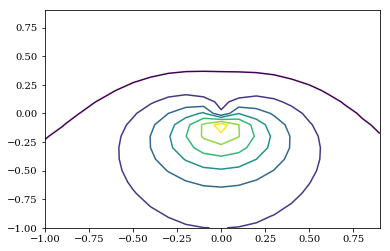

In [8]:
plt.contour(X,Y,P3D[:,:,0])

In [10]:
ipv.quickvolshow(P3D)

A Jupyter Widget